<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>LLMs for Data Science</h1>
<h1>PandasAI</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3

import pandasai
from pandasai import SmartDataframe, SmartDatalake, Agent
from pandasai.llm import OpenAI
from pandasai.connectors import SqliteConnector

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 49e076670ec0bd6b92a0d49d5482c2ef02875080

matplotlib: 3.8.0
watermark : 2.4.3
numpy     : 1.26.4
pandasai  : 2.2.14
pandas    : 1.5.3
sqlite3   : 2.6.0



Load default figure style

In [3]:
#plt.style.use('./d4sci.mplstyle')

# SmartDataframe

In [4]:
sales_by_country = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany", "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "sales": [5000, 3200, 2900, 4100, 2300, 2100, 2500, 2600, 4500, 7000]
})
sales_by_country

,country,sales
0,United States,5000
1,United Kingdom,3200
2,France,2900
3,Germany,4100
4,Italy,2300
5,Spain,2100
6,Canada,2500
7,Australia,2600
8,Japan,4500
9,China,7000


Unless we specify otherwise, it will default to BambooLLM

In [5]:
df = SmartDataframe(sales_by_country)
df.chat('Which are the top 5 countries by sales?')

'The top 5 countries by sales are: China, United States, Japan, Germany, United Kingdom'

We create an OpenAI instance (with our own api key)

In [6]:
openai = OpenAI()

And provide it to the SmartDataframe

In [7]:
df = SmartDataframe(sales_by_country, config={"llm": openai})

Which we can interact with by asking specific questions

In [8]:
df.chat('Which are the top 5 countries by sales?')

'The top 5 countries by sales are: China, United States, Japan, Germany, United Kingdom'

Questions can be almost arbitrarily complex, as long as the LLM is able to understand them :D

In [9]:
df.chat('which countries have 5000 sales or more?')

{'type': 'dataframe', 'value':          country  sales
0  United States   5000
9          China   7000}


,country,sales
0,United States,5000
9,China,7000


# SmartDatalake

To interact with multiple dataframes we must use a SmartDatalake. We start by defining a couple of small data dictionaries

In [10]:
employees_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Name': ['John', 'Emma', 'Liam', 'Olivia', 'William'],
    'Department': ['HR', 'Sales', 'IT', 'Marketing', 'Finance']
}

salaries_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Salary': [5000, 6000, 4500, 7000, 5500]
}

That we load into individual pandas Dataframe objects (these could also be SmartDataframes instead)

In [11]:
employees_df = pd.DataFrame(employees_data)
salaries_df = pd.DataFrame(salaries_data)

Which we can now pass to our Smartdatalake constructor

In [12]:
lake = SmartDatalake([employees_df, salaries_df], config={"llm": openai})

And interact with just as before

In [13]:
lake.chat("Who gets paid the most?")

{'type': 'string', 'value': 'The highest paid employee is Olivia with a salary of 7000.'}


'The highest paid employee is Olivia with a salary of 7000.'

Please not that to answer this question, PandasAI had a to perform a join between the two data frames 

In [14]:
joint_df = employees_df.merge(salaries_df, on='EmployeeID')
joint_df

,EmployeeID,Name,Department,Salary
0,1,John,HR,5000
1,2,Emma,Sales,6000
2,3,Liam,IT,4500
3,4,Olivia,Marketing,7000
4,5,William,Finance,5500


And then select the Name corresponding to the largest Salary

In [15]:
joint_df.iloc[joint_df['Salary'].idxmax()].Name

'Olivia'

# SqliteConnector

We instantiate a SqliteConnector with all the necessary information about our table

In [16]:
employee_connector = SqliteConnector(config={
    "database" : "data/Northwind_small.sqlite",
    "table" : "Employee",
})

Which we can use as just any other data source

In [17]:
employee = SmartDataframe(employee_connector)

In [18]:
employee.chat('How many records are there ?')

9

Which we can easily confirm

In [19]:
con = sqlite3.connect("data/Northwind_small.sqlite")

In [20]:
pd.read_sql_query("SELECT COUNT(*) FROM employee;", con)

,COUNT(*)
0,9


Let us now create a SmartDatalake with a few other tables. We have to create a connector for each of them

In [21]:
territory_connector = SqliteConnector(config={
    "database" : "data/Northwind_small.sqlite",
    "table" : "EmployeeTerritory",
})

shipper_connector = SqliteConnector(config={
    "database" : "data/Northwind_small.sqlite",
    "table" : "Shipper",
})

detail_connector = SqliteConnector(config={
    "database" : "data/Northwind_small.sqlite",
    "table" : "OrderDetail",
})

In [22]:
northwind = Agent([
    employee_connector, 
    territory_connector, 
    shipper_connector, 
    detail_connector
], 
config={"llm": openai})

In [23]:
northwind.chat("Generate a table with employee first name, last name and territory id")

,FirstName,LastName,TerritoryId
0,Nancy,Davolio,6897
1,Nancy,Davolio,19713
2,Andrew,Fuller,1581
3,Andrew,Fuller,1730
4,Andrew,Fuller,1833
5,Andrew,Fuller,2116
6,Andrew,Fuller,2139
7,Andrew,Fuller,2184
8,Andrew,Fuller,40222
9,Janet,Leverling,30346


In [24]:
northwind.chat("Compute how many employees work in each territory");

{'type': 'dataframe', 'value':     TerritoryId  EmployeeCount
0          6897              1
1         98004              1
2         98104              1
3         60179              1
4         60601              1
5         80202              1
6         80909              1
7         90405              1
8         94025              1
9         94105              1
10        95008              1
11        95054              1
12        95060              1
13        19428              1
14        44122              1
15        45839              1
16        53404              1
17         3049              1
18         3801              1
19        48075              1
20        48084              1
21        48304              1
22        55113              1
23        98052              1
24        85251              1
25        19713              1
26        85014              1
27         1581              1
28         1730              1
29         1833              1
30      

Which again required the LLM to figure out the not so trivial JOIN to perform

In [25]:
pd.read_sql_query("""
SELECT 
    TerritoryID, 
    COUNT(DISTINCT EmployeeID) AS EmployeeCount
FROM EmployeeTerritory 
JOIN Employee ON Employee.ID=EmployeeID 
GROUP BY 1
""", con)

,TerritoryId,EmployeeCount
0,01581,1
1,01730,1
2,01833,1
3,02116,1
4,02139,1
5,02184,1
6,02903,1
7,03049,1
8,03801,1
9,06897,1


And we can confirm the way the agent is thinking

In [26]:
print(northwind.explain())

To create the code, I started by thinking about the information we needed: the names of employees and the territories they belong to. First, I combined two sets of information: one that had employee details and another that listed which territory each employee is associated with.

Once I had this combined information, I focused on counting how many employees are in each territory. I organized the data so that it clearly showed each territory alongside the number of employees working there. Finally, I prepared the results in a way that makes it easy to understand and use. The end result is a clear summary of how many employees are in each territory.


In [27]:
territory = SmartDataframe(territory_connector)

In [28]:
territory.chat('Compute the number of territories by employeeid')

,EmployeeId,NumTerritories
0,1,2
1,2,7
2,3,4
3,4,3
4,5,7
5,6,5
6,7,10
7,8,4
8,9,7


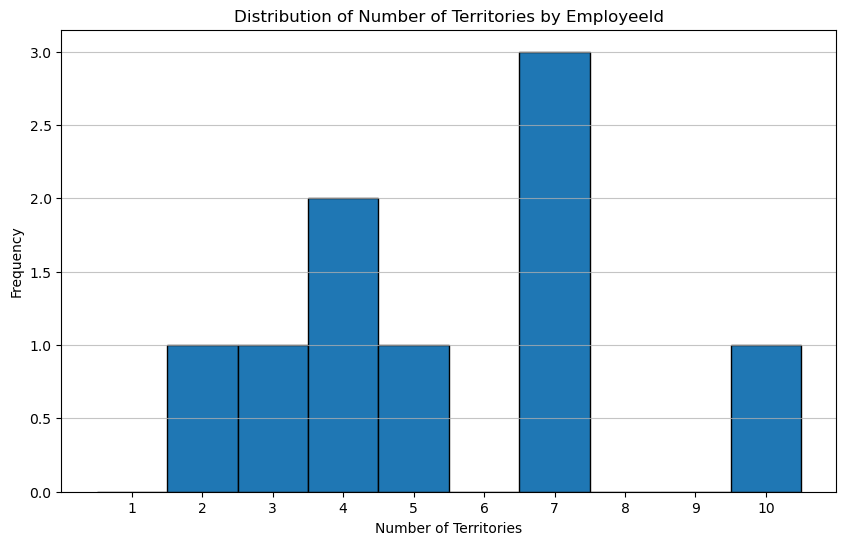

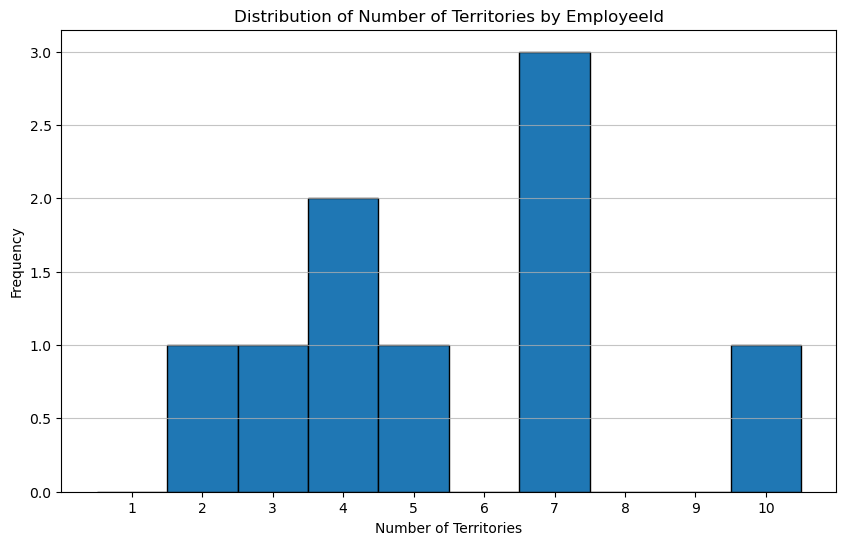

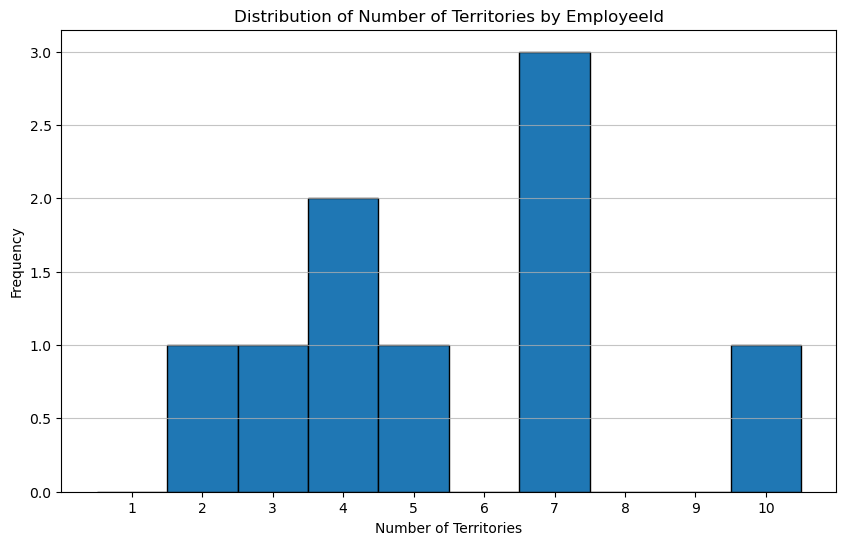

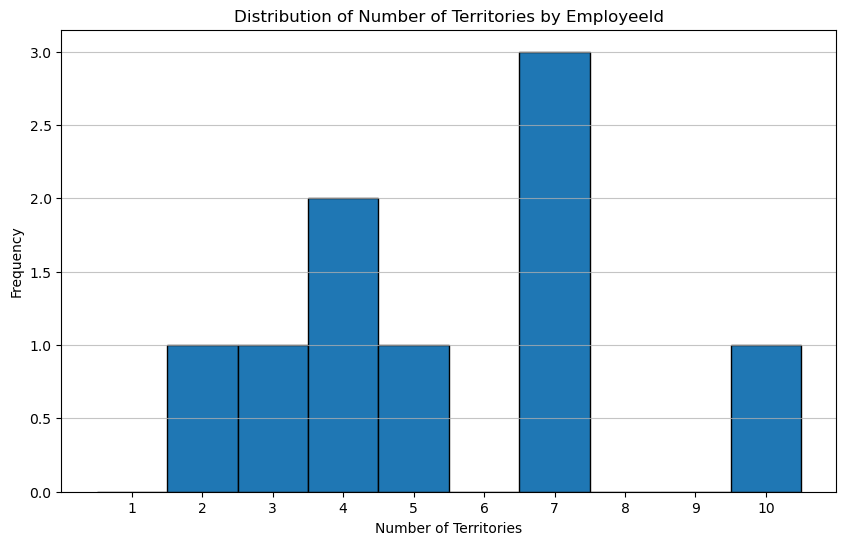

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 113, in execute
    raise e
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 175, in execute_code
    raise NoResultFoundError("No result retur

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo result returned\n'

In [29]:
territory.chat('Visualize the distribution of number of territories by employeeid')

In [30]:
!ls exports/charts/

temp_chart.png


In [31]:
!open exports/charts/temp_chart.png

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>